In [3]:
import numpy as np
import pandas as pd

from learning_machines_drift import FileBackend, Monitor, Registry, datasets
from learning_machines_drift.display import Display
from typing import Dict, Tuple

def generate_features_labels_latents(numrows:int)->Tuple[np.ndarray,np.ndarray,np.ndarray]:
    X, Y, latents =datasets.logistic_model(
        x_mu=np.array([0.0, 0.0, 0.0]), size=numrows, return_latents=True)
    
    features_df:pd.DataFrame = pd.DataFrame(
    {
        "age": X[:, 0],
        "height": X[:, 1],
        "ground-truth-label": Y
    })

    predictions_series:pd.Series = pd.Series(Y)
    latents_df:pd.DataFrame = pd.DataFrame({"latents": latents})
    return (features_df, predictions_series, latents_df)
    
def get_detector_reference(features_df:pd.DataFrame, predictions_series:pd.Series, latents_df:pd.DataFrame)->Registry:
    detector = Registry(tag="simple_example", backend=FileBackend("my-data"))
    detector.register_ref_dataset(
    features=features_df, labels=predictions_series, latents=latents_df)
    return detector

def log_new_data(detector:Registry, features_df:pd.DataFrame, predictions_series:pd.Series, latents_df:pd.DataFrame)->None:
    # Log features
    with detector:
        detector.log_features(features_df)
        detector.log_labels(predictions_series)
        detector.log_latents(latents_df)

def load_data()->Monitor:
    measure = Monitor(tag="simple_example", backend=FileBackend("my-data"))
    measure.load_data()
    return measure

def main():
    features_df, predictions_series, latents_df = generate_features_labels_latents(10)
    detector:Registry = get_detector_reference(features_df, predictions_series, latents_df)
    # Log our reference dataset
    num_iterations = 3
    for iter in range(num_iterations):
        new_features_df, new_predictions_series, new_latents_df = generate_features_labels_latents(5)
        log_new_data(detector, new_features_df, new_predictions_series, new_latents_df)
    
    measure = load_data()
    
    ks_results = measure.hypothesis_tests.scipy_kolmogorov_smirnov()
    perm_results = measure.hypothesis_tests.scipy_permutation()
    log_results = measure.hypothesis_tests.logistic_detection_custom(score_type="roc_auc")

    for res in [ks_results, perm_results, log_results]:
        df = Display().table(res)
        fig, axs = Display().plot(res, score_type="statistic")


Method: SciPy Kolmogorov Smirnov
Description:


Method: SciPy Permutation Test (test function: mean)
Description: Performs permutation test on all features with passed stat_fn
measuring the difference between samples.


Method: Logistic Detection (scoring: roc_auc, normalize: False)
Description: Detection metric based on a LogisticRegression classifier from
scikit-learn with custom scoring.

|                    |   pvalue |   statistic |
|:-------------------|---------:|------------:|
| age                | 0.953414 |   0.2       |
| height             | 0.85373  |   0.233333  |
| ground-truth-label | 1        |   0.0666667 |
| 0                  | 1        |   0.0666667 |
| latents            | 0.731542 |   0.266667  |


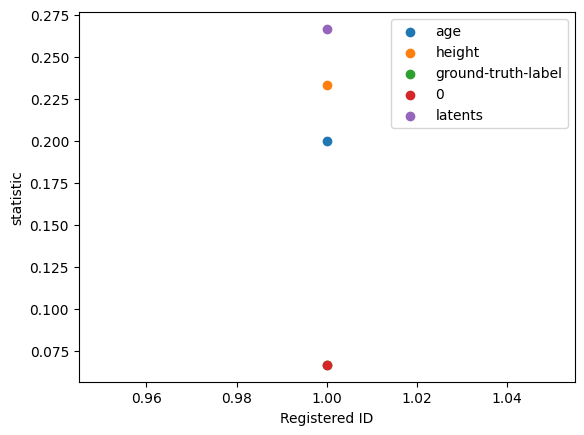

|                    |   pvalue |   statistic |
|:-------------------|---------:|------------:|
| age                |   0.7616 |   0.105127  |
| height             |   0.857  |  -0.0817021 |
| ground-truth-label |   1      |  -0.0666667 |
| 0                  |   1      |  -0.0666667 |
| latents            |   0.8048 |   0.0239711 |


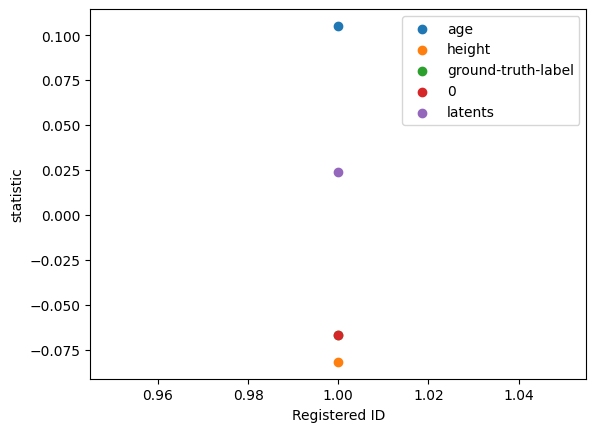

|                            |   statistic |   pvalue |
|:---------------------------|------------:|---------:|
| logistic_detection_roc_auc |    0.205556 |      nan |


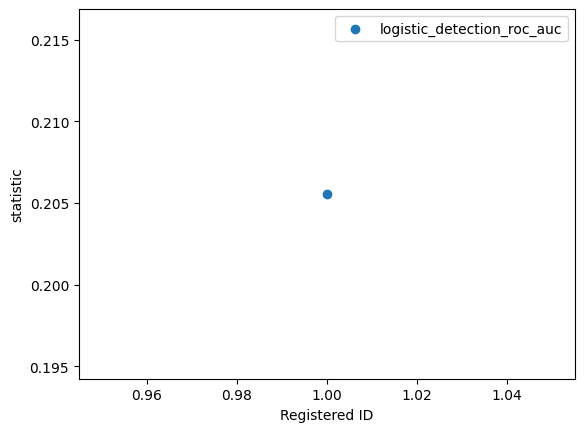

In [4]:
main()